In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

In [79]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')

In [80]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [81]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [82]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [83]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [84]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [85]:
train_df.loc[:, ['Name', 'Ticket', 'Cabin']].nunique()

Name      891
Ticket    681
Cabin     147
dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

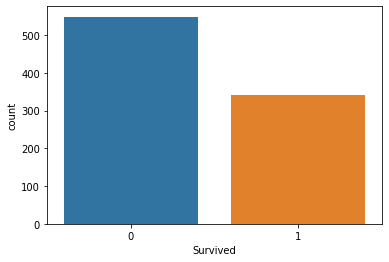

In [86]:
sns.countplot(x='Survived', data=train_df)

<AxesSubplot:xlabel='Sex', ylabel='count'>

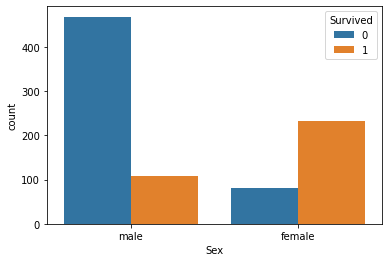

In [87]:
sns.countplot(x='Sex', hue='Survived', data=train_df)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

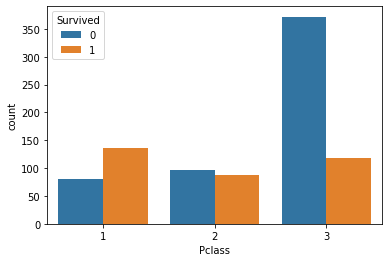

In [88]:
sns.countplot(x='Pclass', hue='Survived', data=train_df)

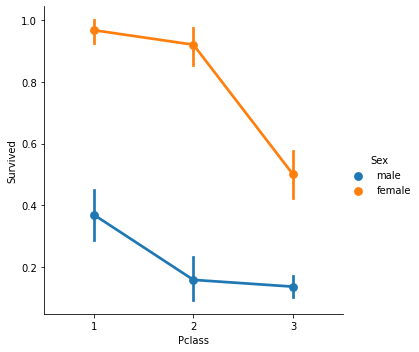

In [89]:
sns.catplot(x='Pclass', y='Survived', hue='Sex', data=train_df, kind='point')

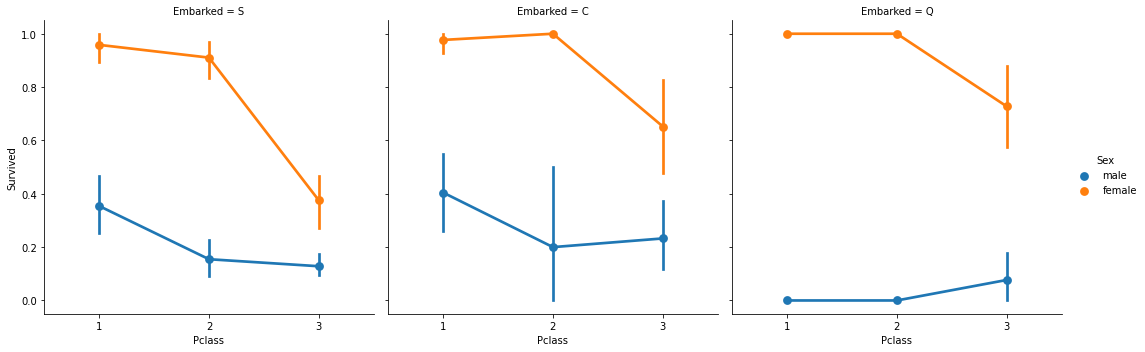

In [90]:
sns.catplot(x='Pclass', y='Survived', hue='Sex', col='Embarked', data=train_df, kind='point')

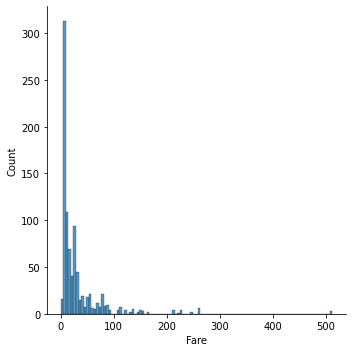

In [91]:
sns.displot(train_df['Fare'])

In [92]:
train_df[train_df['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [93]:
train_df[train_df['Pclass']==1].groupby(by='Embarked')['Fare'].median()

Embarked
C    78.2667
Q    90.0000
S    52.0000
Name: Fare, dtype: float64

In [94]:
train_df['Embarked'].fillna('C', inplace=True)

In [95]:
united_data = [train_df, test_df]
for data in united_data:
    data['Acronym'] = 0
    for _ in data:
        data['Acronym'] = data['Name'].str.extract(r'([A-Za-z]+)\.')

In [96]:
train_df['Acronym'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Acronym, dtype: int64

In [97]:
test_df['Acronym'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Acronym, dtype: int64

In [98]:
for data in united_data:
    data['Acronym'].replace(['Dr', 'Rev', 'Major', 'Col', 'Capt', 'Countess', 'Sir', 'Lady', 'Don', 'Dona', 'Jonkheer'], 'Rare', inplace=True)
    data['Acronym'].replace(['Mlle', 'Ms', 'Mme'], ['Miss', 'Mrs', 'Mrs'], inplace=True)

In [99]:
train_df.groupby(by='Acronym')['Age'].mean()

Acronym
Master     4.574167
Miss      21.804054
Mr        32.368090
Mrs       35.718182
Rare      45.545455
Name: Age, dtype: float64

In [101]:
test_df.groupby(by='Acronym')['Age'].mean()

Acronym
Master     7.406471
Miss      21.774844
Mr        32.000000
Mrs       38.903226
Rare      43.833333
Name: Age, dtype: float64

In [103]:
train_df['Age'] = train_df['Age'].fillna(train_df.groupby('Acronym')['Age'].transform('mean'))
test_df['Age'] = test_df['Age'].fillna(test_df.groupby('Acronym')['Age'].transform('mean'))

In [104]:
train_df.groupby(by='Acronym')['Age'].mean()

Acronym
Master     4.574167
Miss      21.804054
Mr        32.368090
Mrs       35.718182
Rare      45.545455
Name: Age, dtype: float64

In [105]:
test_df.groupby(by='Acronym')['Age'].mean()

Acronym
Master     7.406471
Miss      21.774844
Mr        32.000000
Mrs       38.903226
Rare      43.833333
Name: Age, dtype: float64

In [28]:
pass_id_train = train_df['PassengerId']
pass_id_test = test_df['PassengerId']
y_train = np.array(train_df['Survived'])

In [ ]:
train_df['Family_size'] = train_df['SibSp'] + train_df['Parch']
test_df['Family_size'] = test_df['SibSp'] + test_df['Parch']

In [ ]:
train_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)
test_df.drop(['SibSp', 'Parch'], axis=1, inplace=True)

In [ ]:
SimpleImputer.get_feature_names_out = (lambda self, names=None: self.feature_names_in_)

In [ ]:
pipe_embarked = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

In [ ]:
transformer = make_column_transformer(
    (pipe_embarked, ['Embarked']),
    (SimpleImputer(strategy='mean'), ['Age']),
    (OneHotEncoder(drop='if_binary'), ['Sex', 'Pclass']),
    ('passthrough', ['Family_size']),
    n_jobs=-1)

In [ ]:
pd.DataFrame(transformer.fit_transform(train_df), columns=transformer.get_feature_names_out())

In [ ]:
clf = DecisionTreeClassifier(random_state=17)

In [ ]:
pipe_model = make_pipeline(transformer, clf)

In [ ]:
pipe_model.get_params().keys()

In [ ]:
parameters = {}
parameters['decisiontreeclassifier__max_depth'] = [i for i in range(2, 10, 2)]
parameters['decisiontreeclassifier__min_samples_split'] = [i for i in range(2, 11)]
parameters['decisiontreeclassifier__min_samples_leaf'] = [i for i in range(1, 11)]

In [ ]:
gccv = GridSearchCV(pipe_model, parameters, cv=5,  scoring = 'accuracy', n_jobs=-1)

In [ ]:
gccv.fit(train_df, y_train)

In [ ]:
gccv.best_params_

In [ ]:
gccv.best_score_

In [ ]:
gccv.score(train_df, y_train)

In [ ]:
predictions = gccv.predict(test_df)

In [ ]:
output = pd.DataFrame({'PassengerId': pass_id_test, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

In [ ]:
output